In [1]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
from GmGM import Dataset, GmGM
from strong_product_model import strong_product_model
from utilities import vec_kron_sum, sim_diag
import random
import BiGLasso_Methods as bg
from typing import Literal
from sklearn.metrics import auc

SEED = 0

# Make palette colorblind friendly
plt.style.use('tableau-colorblind10')
hatches = ['|', '//', 'oo', 'x', '+', '-', 'OO', '.', '*', '\\']
lines = ['-', '--', '-.', ':', (0, (3, 5, 1, 5, 1, 5))]

# Prevent type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def fast_strong_product(
    Psi_1: np.ndarray,
    Psi_2w: np.ndarray,
    Psi_2b: np.ndarray,
) -> np.ndarray:
    """
    Generates random sample from given parameters
    of the strong product model.
    """
    Theta = Psi_2b + np.eye(Psi_2b.shape[0])
    P, D = sim_diag(Theta, Psi_2w)
    Lam, V = np.linalg.eigh(Psi_1)
    core = 1 / vec_kron_sum([Lam, D])

    # Generate sample
    z = np.random.normal(size=Psi_1.shape[0] * Psi_2w.shape[0])
    z *= np.sqrt(core)
    Z = V @ z.reshape(Psi_1.shape[0], Psi_2w.shape[0]) @ np.linalg.inv(P)

    return Z

fast_strong_product(np.eye(5), np.eye(7), np.eye(7))
    

array([[ 0.21745458, -0.20041139, -0.43763033, -0.38946189, -0.06719427,
        -0.24029993,  1.17862429],
       [ 0.14280743, -0.48008121, -0.57813695, -0.37209883, -0.05501246,
         0.62651695, -0.14541808],
       [-0.20049828,  0.97165411,  0.57271829, -1.39182447, -0.45866681,
         0.21721722, -0.21652352],
       [ 0.25992953,  0.55729863, -0.53616069, -0.03028274, -0.24972793,
        -0.33915754,  0.21065549],
       [ 0.22945377, -0.48368542,  0.50822125, -0.44752116, -0.12058047,
        -0.30767286, -0.9315787 ]])

In [3]:
def fast_kronecker_sum_model(
    Psi_1: np.ndarray,
    Psi_2: np.ndarray,
) -> np.ndarray:
    """
    Generates random sample from given parameters
    of the strong product model.
    """
    Lam1, V1 = np.linalg.eigh(Psi_1)
    Lam2, V2 = np.linalg.eigh(Psi_2)
    core = 1 / vec_kron_sum([Lam1, Lam2])

    # Generate sample
    z = np.random.normal(size=Psi_1.shape[0] * Psi_2.shape[0])
    z *= np.sqrt(core)
    Z = V1 @ z.reshape(Psi_1.shape[0], Psi_2.shape[0]) @ V2.T

    return Z

fast_kronecker_sum_model(np.eye(5), np.eye(7))
    

array([[ 0.43484615, -0.60298487, -0.06284085, -1.10774399, -0.8145185 ,
        -0.85423188,  0.28486372],
       [-0.08209254, -0.63685301, -0.37085815, -0.28944351,  0.31762967,
        -0.45555511, -1.34424878],
       [ 0.25405018,  0.90004621, -0.90975134, -0.49511663,  0.75193846,
         0.29696892, -0.00940235],
       [-1.3362856 , -0.08931794,  0.05441661,  0.35792447,  0.40851479,
         0.95777521,  0.97105773],
       [-0.1657562 ,  0.38401811, -0.57639392,  1.42334072,  0.49603681,
         0.3976134 , -0.21843758]])

In [4]:
def fast_kronecker_product_model(
    Psi_1: np.ndarray,
    Psi_2: np.ndarray,
) -> np.ndarray:
    """
    Generates random sample from given parameters
    of the strong product model.
    """
    Lam1, V1 = np.linalg.eigh(Psi_1)
    Lam2, V2 = np.linalg.eigh(Psi_2)
    core = 1 / np.kron(Lam1, Lam2)

    # Generate sample
    z = np.random.normal(size=Psi_1.shape[0] * Psi_2.shape[0])
    z *= np.sqrt(core)
    Z = V1 @ z.reshape(Psi_1.shape[0], Psi_2.shape[0]) @ V2.T

    return Z

fast_kronecker_product_model(np.eye(5), np.eye(7))
    

array([[ 0.89687962,  2.09517715, -1.21065732,  1.4127549 ,  0.99094724,
        -0.47845285,  1.46990737],
       [-0.76664807,  1.20971017,  0.06484753, -1.52175364, -0.41439335,
         0.56340968, -0.05354016],
       [ 1.08451257,  0.62704889, -1.05471859,  0.54503892,  0.29719494,
        -0.09333011, -0.64035683],
       [ 0.76014766, -0.70248638,  0.61671071, -0.21766784, -1.08535761,
        -0.2956281 ,  1.36828763],
       [-0.53432812, -0.59707613, -0.22743364,  0.63873126,  0.36254197,
        -1.22079863,  1.14993065]])

In [5]:
def pr_curve(
    ground_truth: np.ndarray,
    output: np.ndarray,
    num_points: int = 1000
) -> tuple[np.ndarray, np.ndarray]:
    """
    Inputs:
        ground_truth: Adjacency matrix of graph
        output: Output of algorithm
        num_points: Number of points to sample

    Outputs:
        (precisions, recalls): Precision-recall curve
    """
    # Setup
    precisions = np.zeros(num_points)
    recalls = np.zeros(num_points)
    thresholds = np.linspace(-0.1, np.max(output), num_points)

    ground_truth = ground_truth != 0
    np.fill_diagonal(ground_truth, 0)

    if (output == np.eye(output.shape[0])).all():
        return None, None

    # Iterate over thresholds
    for i, threshold in enumerate(thresholds):
        # Threshold output
        output_thresholded = (output > threshold).astype(int)
        np.fill_diagonal(output_thresholded, 0)

        # Calculate precision and recall
        true_positives = np.sum(output_thresholded * ground_truth)
        false_positives = np.sum(output_thresholded * (1 - ground_truth))
        false_negatives = np.sum((1 - output_thresholded) * ground_truth)

        if true_positives + false_positives == 0:
            precisions[i] = 1
            recalls[i] = 0
        else:
            precisions[i] = true_positives / (true_positives + false_positives)
            recalls[i] = true_positives / (true_positives + false_negatives)

    return precisions, recalls

def pr_curve_alg(
    ground_truth: np.ndarray,
    alg: callable,
    reg_params: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """
    Inputs:
        ground_truth: Adjacency matrix of graph
        output: Output of algorithm
        num_points: Number of points to sample

    Outputs:
        (precisions, recalls): Precision-recall curve
    """
    # Setup
    precisions = np.zeros(reg_params.shape[0])
    recalls = np.zeros(reg_params.shape[0])
    #thresholds = np.linspace(0, np.max(output), num_points)

    ground_truth = ground_truth != 0
    np.fill_diagonal(ground_truth, 0)

    # Iterate over reg_params
    for i, param in enumerate(reg_params):
        # Threshold output
        print(f"TeraLasso lambda: {param}")
        output = alg(param)
        output_thresholded = (output != 0).astype(int)
        np.fill_diagonal(output_thresholded, 0)

        # Calculate precision and recall
        true_positives = np.sum(output_thresholded * ground_truth)
        false_positives = np.sum(output_thresholded * (1 - ground_truth))
        false_negatives = np.sum((1 - output_thresholded) * ground_truth)

        if true_positives + false_positives == 0:
            precisions[i] = 1
            recalls[i] = 0
        else:
            precisions[i] = true_positives / (true_positives + false_positives)
            recalls[i] = true_positives / (true_positives + false_negatives)

    return precisions, recalls

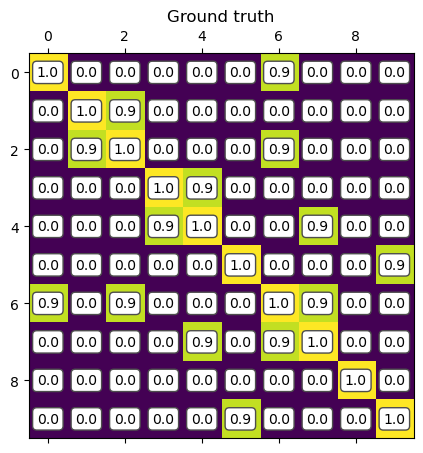

In [6]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 10
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
ground_truth = np.array(graph.get_adjacency().data)
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
ax1.matshow(ground_truth)
ax1.set_title("Ground truth")

for (i, j), z in np.ndenumerate(ground_truth):
    ax1.text(
        j,
        i,
        '{:0.1f}'.format(z),
        ha='center',
        va='center',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
    )

In [7]:
# Create a random graph
def random_graph(graph):
    ground_truth = np.array(graph.get_adjacency().data)
    gt_sums = 1 / np.sqrt(ground_truth.sum(axis=0))
    ground_truth = gt_sums.reshape(1, -1) * ground_truth * gt_sums.reshape(-1, 1)

    # Add diagonal so that it forms a PSD matrix!
    ground_truth = ground_truth / 1.1 + np.eye(num_nodes)
    return ground_truth

def precision_test(
    num_nodes: int,
    graphs: list[ig.Graph],
    title: str,
    num_trials: int = 10,
    model: Literal[
        "Strong Product",
        "Kronecker Sum",
        "Kronecker Product"
    ] = "Strong Product",
    cb_cw_ratio: float = 1.0
) -> tuple[plt.Figure, plt.Axes]:
    random.seed(SEED)
    np.random.seed(SEED)
    
    ground_truth_r = random_graph(graphs[0])
    ground_truth_cw = random_graph(graphs[1]) / np.sqrt(cb_cw_ratio)
    ground_truth_cb = np.sqrt(cb_cw_ratio) * random_graph(graphs[2])

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))


    algorithms = (
        [
            "Strong Product",
            "GmGM",
            #"TeraLasso",
        ]
    )
    for idx, algorithm in enumerate(algorithms):
        print(f"Running {algorithm}")
        ps_r = []
        rs_r = []
        ps_cw = []
        rs_cw = []
        ps_cb = []
        rs_cb = []

        for i in range(num_trials):
            print(f"\tTrial {i+1} of {num_trials}")

            # Generate data
            #dfs = num_nodes
            #data_dependencies = stats.wishart(df=dfs, scale=np.eye(num_nodes)).rvs()
            #data_dependencies /= dfs
            if model == "Strong Product":
                output = fast_strong_product(
                    ground_truth_r,
                    ground_truth_cw,
                    ground_truth_cb
                )
            elif model == "Kronecker Sum":
                output = fast_kronecker_sum_model(
                    ground_truth_r,
                    ground_truth_cw
                )
            elif model == "Kronecker Product":
                output = fast_kronecker_product_model(
                    ground_truth_r,
                    ground_truth_cb
                )
            else:
                raise Exception(f"Unknown model: {model}")

            dataset = Dataset(
                dataset={"data": output[np.newaxis, :, :]},
                structure={"data": ("", "rows", "columns")}
            )
            result = None
            run_alg = None
            if algorithm == "GmGM":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = np.eye(num_nodes)
                        self.precision_matrices["cols_within_rows"] = precmats["columns"]
                result = GmGM(
                    dataset,
                    to_keep=0.5,
                    threshold_method="statistical-significance",
                    min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                    n_comps=None,
                    verbose=False,
                    centering_method=None,
                    use_nonparanormal_skeptic=False,
                    nonparanormal_evec_backend="COCA",
                    readonly=False,
                    calculate_explained_variance=True,
                    batch_size=1000
                )
                result = result_container(result.precision_matrices)
            elif algorithm == "Strong Product":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = precmats["cols_between_rows"]
                        self.precision_matrices["cols_within_rows"] = precmats["cols_within_rows"]
                result = strong_product_model(
                    data_matrix=output,
                    rho_rows=0.1,
                    rho_cols_within_rows=0.1,
                    rho_cols_between_rows=0.1,
                    verbose=False,
                    tol=1e-3
                )
                result = result_container(result)
            elif algorithm == "TeraLasso":
                def alg(reg_param):
                    return bg.TeraLasso(
                        dataset,
                        reg_param,
                        use_nonparanormal_skeptic=False
                    ).precision_matrices["rows"].toarray()
                run_alg = alg
            else:
                raise Exception(f"Unknown algorithm: {algorithm}")

            if run_alg is None:
                if hasattr(result.precision_matrices["rows"], 'toarray'):
                    result.precision_matrices["rows"] = result.precision_matrices["rows"].toarray()
                if hasattr(result.precision_matrices["cols_within_rows"], 'toarray'):
                    result.precision_matrices["cols_within_rows"] = \
                        result.precision_matrices["cols_within_rows"].toarray()
                if hasattr(result.precision_matrices["cols_between_rows"], 'toarray'):
                    result.precision_matrices["cols_between_rows"] = \
                        result.precision_matrices["cols_between_rows"].toarray()
                ys_r, xs_r = pr_curve(ground_truth_r, result.precision_matrices["rows"])
                ys_cw, xs_cw = pr_curve(ground_truth_cw, result.precision_matrices["cols_within_rows"])
                ys_cb, xs_cb = pr_curve(ground_truth_cb, result.precision_matrices["cols_between_rows"])
            else:
                # Manually chosen bounds to cover span from ~perfect recall to ~perfect precision
                if algorithm == "TeraLasso":
                    reg_params = 10**np.linspace(-2, 0, 25)
                ys_r, xs_r = pr_curve_alg(ground_truth_r, run_alg, reg_params)
                ys_cw, xs_cw = pr_curve_alg(ground_truth_cw, run_alg, reg_params)
                ys_cb, xs_cb = pr_curve_alg(ground_truth_cb, run_alg, reg_params)
                #print(ys, xs)
            
            if ys_r is not None and xs_r is not None:
                ps_r.append(ys_r)
                rs_r.append(xs_r)
            if ys_cw is not None and xs_cw is not None:
                ps_cw.append(ys_cw)
                rs_cw.append(xs_cw)
            if ys_cb is not None and xs_cb is not None:
                ps_cb.append(ys_cb)
                rs_cb.append(xs_cb)


        num_points = 100
        xs = np.linspace(0, 1, num_points)

        if algorithm == "GmGM":
            label = "GmGM"
        elif algorithm == "TeraLasso":
            label = "TeraLasso"
        elif algorithm == "Strong Product":
            label = "Strong Product"

        if algorithm == "TeraLasso":
            # Tableau color is too light
            lineplot = ax1.plot(-1, -1, color='#888888')
        elif algorithm == "TeraLasso + mean estimation":
            lineplot = ax1.plot(-1, -1, color='#990000')
        else:
            lineplot = ax1.plot(-1, -1)
        xs = np.linspace(0.01, 1, 100)

        for ps, rs, ax in zip([ps_r, ps_cw, ps_cb], [rs_r, rs_cw, rs_cb], [ax1, ax2, ax3]):
            min_ys = np.zeros(100) + 1
            max_ys = np.zeros(100)
            if len(ps) == 0:
                continue
            for p, r in zip(ps, rs):
                f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
                min_ys = np.minimum(min_ys, f(xs))
                max_ys = np.maximum(max_ys, f(xs))
                #plt.plot(xs, f(xs), color='black', alpha=0.1)
            ax.plot(
                xs,
                min_ys,
                color=lineplot[0].get_color(),
                linestyle=lines[idx],
                alpha=0.3
            )
            ax.plot(
                xs,
                max_ys,
                color=lineplot[0].get_color(),
                linestyle=lines[idx],
                alpha=0.3
            )
            # ax.plot(
            #     xs,
            #     (min_ys + max_ys) / 2,
            #     color=lineplot[0].get_color(),
            #     label=label,
            #     linestyle=lines[idx]
            # )
            ax.plot(
                sum(rs) / len(rs),
                sum(ps) / len(ps),
                color=lineplot[0].get_color(),
                label=label,
                linestyle=lines[idx]
            )
            ax.fill_between(
                xs,
                min_ys,
                max_ys,
                color=lineplot[0].get_color(),
                alpha=0.3
            )#, hatch=hatches[idx]+hatches[idx])

    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()

    ax1.set_title("Rows")
    ax2.set_title("Columns (within-row connections)")
    ax3.set_title("Columns (between-row connections)")

    fig.suptitle(
            f'PR Curves for Barabasi-Albert graph ({num_nodes} nodes)'
            + f'\n [{title}]'
        )

    fig.tight_layout()

    return fig, (ax1, ax2, ax3)

# Run Tests

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


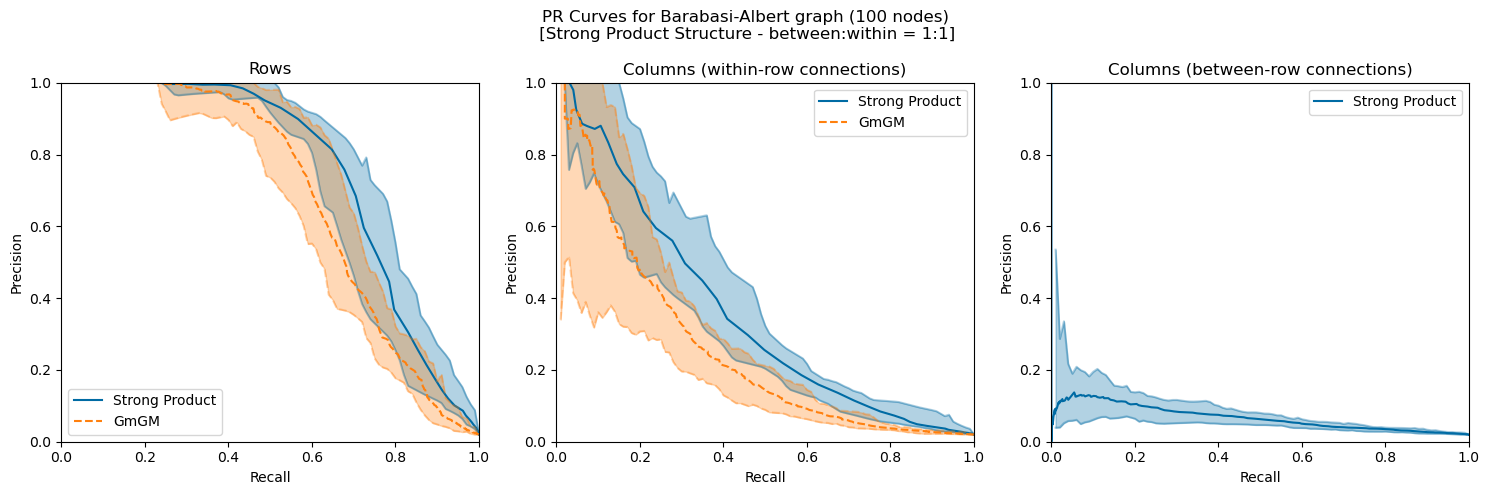

In [18]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 1:1",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=1.0
)
#fig.savefig('./out-figs/synthetic/test.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


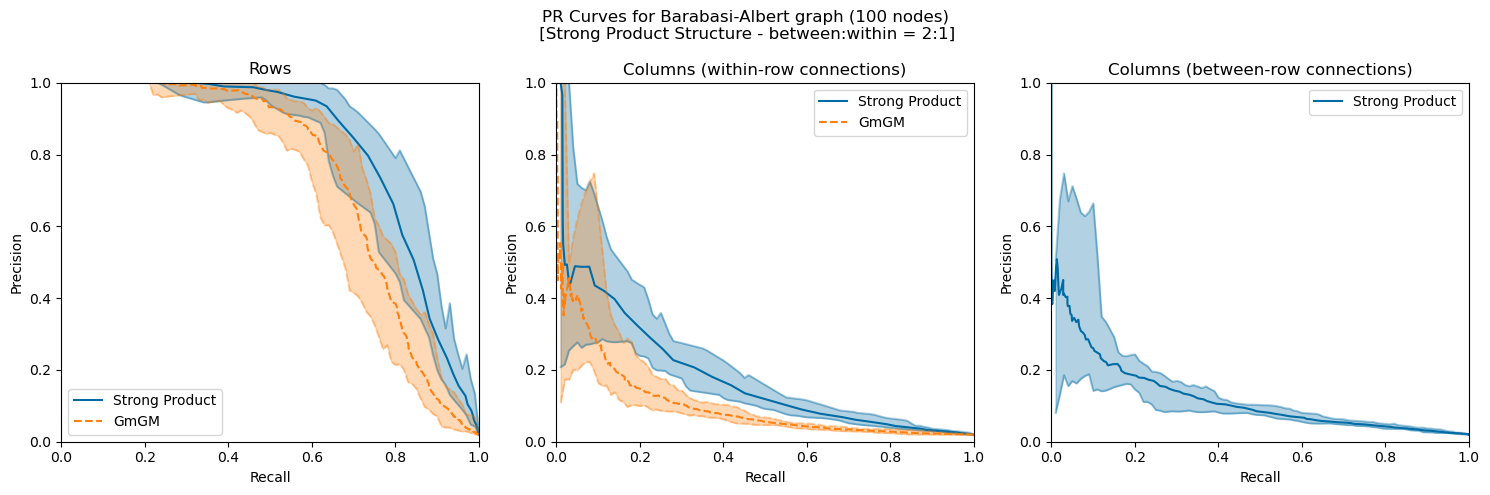

In [21]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 2:1",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=2.0
)
#fig.savefig('./out-figs/synthetic/test.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


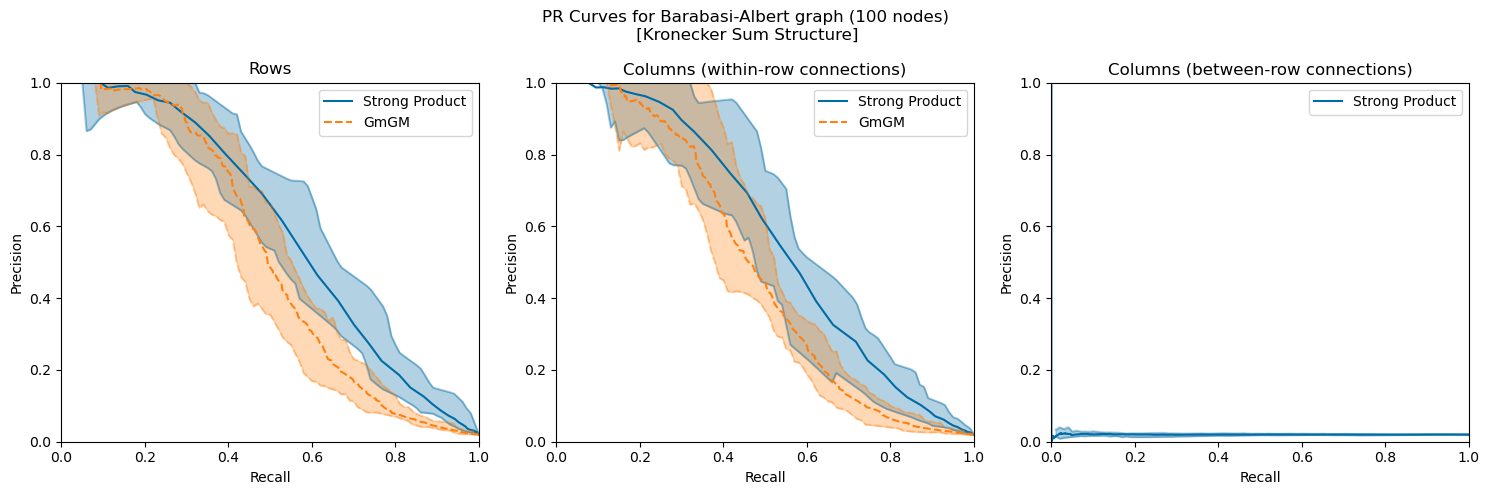

In [10]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Sum Structure",
    num_trials=10,
    model="Kronecker Sum"
)
#fig.savefig('./out-figs/synthetic/test.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


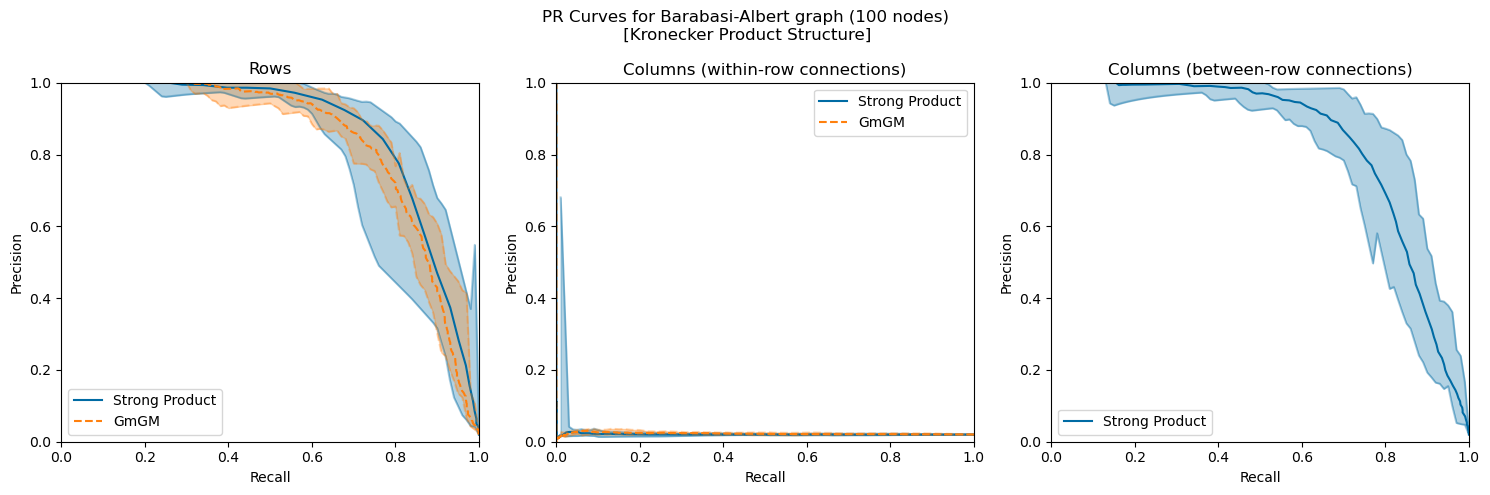

In [11]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Product Structure",
    num_trials=10,
    model="Kronecker Product"
)
#fig.savefig('./out-figs/synthetic/test.pdf', bbox_inches="tight")

# AUPR cb-ratio

In [11]:
def aupr(
    num_nodes: int,
    graphs: list[ig.Graph],
    cb_cw_ratio: float = 1.0,
    row_coefficient: float = 1.0
) -> tuple[float]:

    # Create a random graph
    def random_graph(graph):
        ground_truth = np.array(graph.get_adjacency().data)
        gt_sums = 1 / np.sqrt(ground_truth.sum(axis=0))
        ground_truth = gt_sums.reshape(1, -1) * ground_truth * gt_sums.reshape(-1, 1)

        # Add diagonal so that it forms a PSD matrix!
        ground_truth = ground_truth / 1.1 + np.eye(num_nodes)
        return ground_truth
    
    ground_truth_r = row_coefficient * random_graph(graphs[0])
    ground_truth_cw = random_graph(graphs[1]) / np.sqrt(cb_cw_ratio)
    ground_truth_cb = np.sqrt(cb_cw_ratio) * random_graph(graphs[2])

    ps_r = []
    rs_r = []
    ps_cw = []
    rs_cw = []
    ps_cb = []
    rs_cb = []

    output = fast_strong_product(
        ground_truth_r,
        ground_truth_cw,
        ground_truth_cb
    )

    result = None
    class result_container:
        # Jerry-rigged class to hold the result
        def __init__(self, precmats):
            self.precision_matrices = precmats
            self.precision_matrices["rows"] = precmats["rows"]
            self.precision_matrices["cols_between_rows"] = precmats["cols_between_rows"]
            self.precision_matrices["cols_within_rows"] = precmats["cols_within_rows"]
    result = strong_product_model(
        data_matrix=output,
        rho_rows=0.1,
        rho_cols_within_rows=0.1,
        rho_cols_between_rows=0.1,
        verbose=False,
        tol=1e-3
    )
    result = result_container(result)

    ys_r, xs_r = pr_curve(ground_truth_r, result.precision_matrices["rows"])
    ys_cw, xs_cw = pr_curve(ground_truth_cw, result.precision_matrices["cols_within_rows"])
    ys_cb, xs_cb = pr_curve(ground_truth_cb, result.precision_matrices["cols_between_rows"])
    
    if ys_r is not None and xs_r is not None:
        ps_r.append(ys_r)
        rs_r.append(xs_r)
    if ys_cw is not None and xs_cw is not None:
        ps_cw.append(ys_cw)
        rs_cw.append(xs_cw)
    if ys_cb is not None and xs_cb is not None:
        ps_cb.append(ys_cb)
        rs_cb.append(xs_cb)

    return auc(xs_r, ys_r), auc(xs_cw, ys_cw), auc(xs_cb, ys_cb)

Iteration 1, Ratio 0.01
Iteration 3, Ratio 0.8425
Iteration 5, Ratio 1.675
Iteration 7, Ratio 2.5075
Iteration 9, Ratio 3.34
Iteration 11, Ratio 4.172499999999999
Iteration 13, Ratio 5.005
Iteration 15, Ratio 5.8375
Iteration 17, Ratio 6.67
Iteration 19, Ratio 7.5024999999999995
Iteration 21, Ratio 8.334999999999999
Iteration 23, Ratio 9.1675
Iteration 25, Ratio 10.0


(0.0, 1.0)

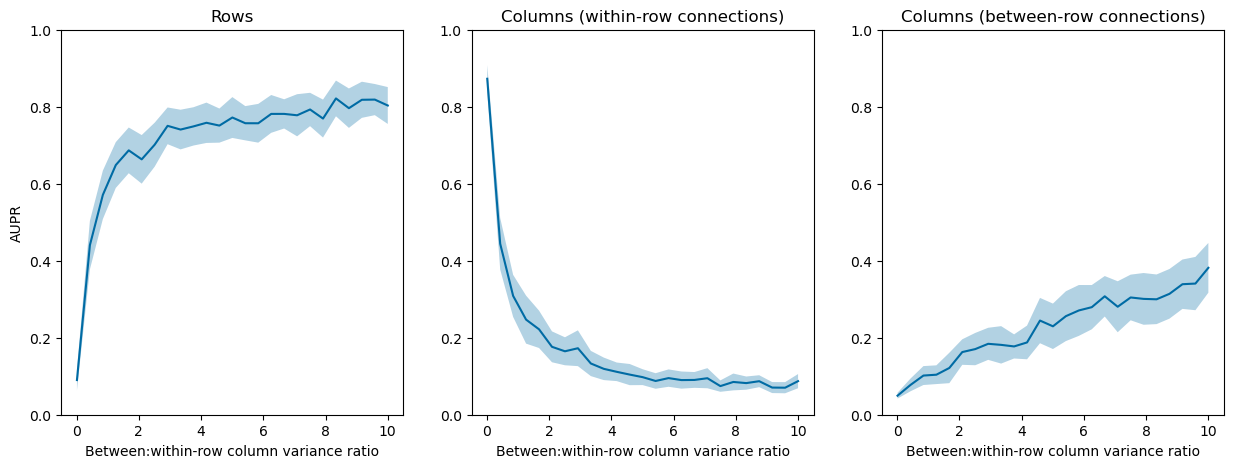

In [57]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 50
num_trials = 50
cb_ratios = np.linspace(0.01, 10, 25)

aus_1 = []
aus_2w = []
aus_2b = []
aus_1_var = []
aus_2w_var = []
aus_2b_var = []

for i, cb_ratio in enumerate(cb_ratios):
    graph1 = ig.Graph.Barabasi(n=num_nodes)
    graph2 = ig.Graph.Barabasi(n=num_nodes)
    graph3 = ig.Graph.Barabasi(n=num_nodes)
    if i % 2 == 0:
        print(f"Iteration {i+1}, Ratio {cb_ratio}")
    _aus_1 = []
    _aus_2w = []
    _aus_2b = []
    for trial in range(num_trials):
        au_1, au_2w, au_2b = aupr(
            num_nodes,
            [graph1, graph2, graph3],
            cb_cw_ratio=cb_ratio
        )
        _aus_1.append(au_1)
        _aus_2w.append(au_2w)
        _aus_2b.append(au_2b)
    aus_1.append(np.mean(_aus_1))
    aus_2w.append(np.mean(_aus_2w))
    aus_2b.append(np.mean(_aus_2b))
    aus_1_var.append(np.var(_aus_1 - aus_1[-1]))
    aus_2w_var.append(np.var(_aus_2w - aus_2w[-1]))
    aus_2b_var.append(np.var(_aus_2b - aus_2b[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.plot(cb_ratios, aus_1, label="Rows")
ax1.set_title("Rows")
ax2.plot(cb_ratios, aus_2w, label="Columns (within-row connections)")
ax2.set_title("Columns (within-row connections)")
ax3.plot(cb_ratios, aus_2b, label="Columns (between-row connections)")
ax3.set_title("Columns (between-row connections)")
ax1.set_xlabel("Between:within-row column variance ratio")
ax2.set_xlabel("Between:within-row column variance ratio")
ax3.set_xlabel("Between:within-row column variance ratio")
ax1.set_ylabel("AUPR")

ax1.fill_between(
    cb_ratios,
    np.array(aus_1) - np.sqrt(np.array(aus_1_var)),
    np.array(aus_1) + np.sqrt(np.array(aus_1_var)),
    alpha=0.3
)
ax2.fill_between(
    cb_ratios,
    np.array(aus_2w) - np.sqrt(np.array(aus_2w_var)),
    np.array(aus_2w) + np.sqrt(np.array(aus_2w_var)),
    alpha=0.3
)
ax3.fill_between(
    cb_ratios,
    np.array(aus_2b) - np.sqrt(np.array(aus_2b_var)),
    np.array(aus_2b) + np.sqrt(np.array(aus_2b_var)),
    alpha=0.3
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

fig.suptitle("AUPR as we increase the between:within-row column variance ratio")
fig.tight_layout()

Iteration 1, Ratio 0.01
Iteration 3, Ratio 0.8425
Iteration 5, Ratio 1.675
Iteration 7, Ratio 2.5075
Iteration 9, Ratio 3.34
Iteration 11, Ratio 4.172499999999999
Iteration 13, Ratio 5.005
Iteration 15, Ratio 5.8375
Iteration 17, Ratio 6.67
Iteration 19, Ratio 7.5024999999999995
Iteration 21, Ratio 8.334999999999999
Iteration 23, Ratio 9.1675
Iteration 25, Ratio 10.0


(0.0, 1.0)

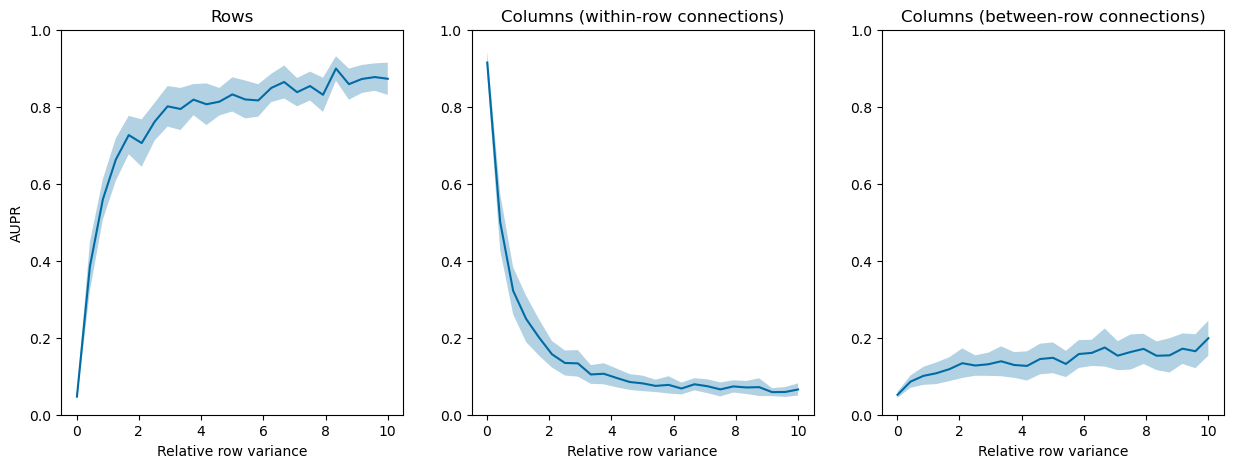

In [56]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 50
num_trials = 50
row_ratios = np.linspace(0.01, 10, 25)

aus_1 = []
aus_2w = []
aus_2b = []
aus_1_var = []
aus_2w_var = []
aus_2b_var = []

for i, row_ratio in enumerate(row_ratios):
    graph1 = ig.Graph.Barabasi(n=num_nodes)
    graph2 = ig.Graph.Barabasi(n=num_nodes)
    graph3 = ig.Graph.Barabasi(n=num_nodes)
    if i % 2 == 0:
        print(f"Iteration {i+1}, Ratio {row_ratio}")
    _aus_1 = []
    _aus_2w = []
    _aus_2b = []
    for trial in range(num_trials):
        au_1, au_2w, au_2b = aupr(
            num_nodes,
            [graph1, graph2, graph3],
            row_coefficient=row_ratio
        )
        _aus_1.append(au_1)
        _aus_2w.append(au_2w)
        _aus_2b.append(au_2b)
    aus_1.append(np.mean(_aus_1))
    aus_2w.append(np.mean(_aus_2w))
    aus_2b.append(np.mean(_aus_2b))
    aus_1_var.append(np.var(_aus_1 - aus_1[-1]))
    aus_2w_var.append(np.var(_aus_2w - aus_2w[-1]))
    aus_2b_var.append(np.var(_aus_2b - aus_2b[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.plot(row_ratios, aus_1, label="Rows")
ax1.set_title("Rows")
ax2.plot(row_ratios, aus_2w, label="Columns (within-row connections)")
ax2.set_title("Columns (within-row connections)")
ax3.plot(row_ratios, aus_2b, label="Columns (between-row connections)")
ax3.set_title("Columns (between-row connections)")
ax1.set_xlabel("Relative row variance")
ax2.set_xlabel("Relative row variance")
ax3.set_xlabel("Relative row variance")
ax1.set_ylabel("AUPR")

ax1.fill_between(
    row_ratios,
    np.array(aus_1) - np.sqrt(np.array(aus_1_var)),
    np.array(aus_1) + np.sqrt(np.array(aus_1_var)),
    alpha=0.3
)
ax2.fill_between(
    row_ratios,
    np.array(aus_2w) - np.sqrt(np.array(aus_2w_var)),
    np.array(aus_2w) + np.sqrt(np.array(aus_2w_var)),
    alpha=0.3
)
ax3.fill_between(
    row_ratios,
    np.array(aus_2b) - np.sqrt(np.array(aus_2b_var)),
    np.array(aus_2b) + np.sqrt(np.array(aus_2b_var)),
    alpha=0.3
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

fig.suptitle("AUPR as we increase the row variance")
fig.tight_layout()

# Convergence

In [30]:
random.seed(SEED)
np.random.seed(SEED)
num_nodes = 50
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)
data = fast_strong_product(
    random_graph(graph1),
    random_graph(graph2),
    random_graph(graph3)
)

results = strong_product_model(
    data_matrix=data,
    rho_rows=0.1,
    rho_cols_within_rows=0.1,
    rho_cols_between_rows=0.1,
    verbose=False,
    tol=1e-100,
    return_errors=True
)

[740.6169353  380.97775214 153.03527031  66.8484164   47.36416334
  46.76808451  46.74946912  46.74016163  46.73550795  46.73318112
  46.7320177   46.73194499  46.73192681  46.73191772  46.73191318
  46.73191091  46.73191034  46.7319102   46.73191013  46.73191009
  46.73191009  46.73191008  46.73191008  46.73191008  46.73191008
  46.73191008  46.73191008]


Text(0.5, 1.0, 'Convergence of strong product model')

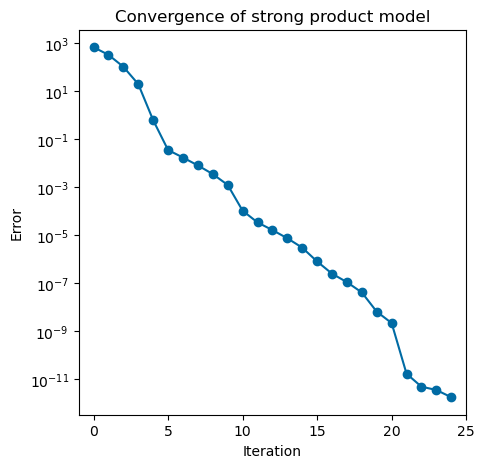

In [31]:
errors = np.array(results["errors"])
print(errors)
errors -= errors[-1]
errors = errors[:-2] # Second-to-last error is same b/c of convergence criterion
errors = np.abs(errors)

# Show convergence over time
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
ax.plot(errors, linestyle='-', marker='o')
ax.set_xlabel("Iteration")
ax.set_ylabel("Error")
ax.set_yscale("log")
ax.set_xlim(-1, len(errors))
ax.set_title("Convergence of strong product model")